<h2>Import necessary packages and create Reddit app to get authentication</h2>

In [2]:
import csv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import praw
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from praw.models import MoreComments
from gensim import models
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from spellchecker import SpellChecker

In [13]:
reddit = praw.Reddit(client_id = '6H7546lxR30Wxg', client_secret='d_KCfElu8xxWmitWR5Gd_7ommzUm9w', user_agent='Reddit Web Scraping')

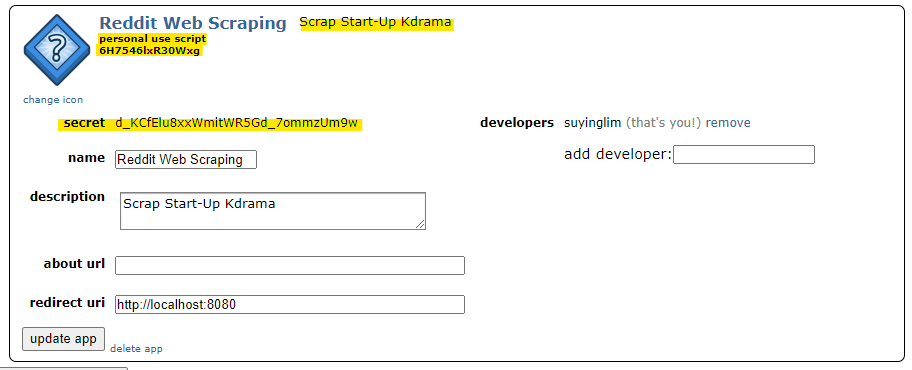

<h2>Subreddit to be scraped from: r/KDRAMA</h2>

In [37]:
sub = ['KDRAMA']
for s in sub:
    subreddit = reddit.subreddit(s)

<h2>Data scrapping and storing</h2>
<ol>
    <li>Query with keyword 'Start-up'</li>
    <li>Create dictionary for posts and comments</li>
    <li>Scrap data for top 20 posts sorted by comments</li>
    <li>Store comments and posts scrapped into csv file</li>
</ol>    

In [91]:
query = ['Start-Up']

for item in query:
    post_dict = {
        'title': [],
        'id': [],
        'comms_num': [],
        'created': [],
    }
    comments_dict = {
        "comment_id": [],
        "comment_parent_id": [],
        "comment_body": [],
        "comment_link_id": [],
    }
    for submission in subreddit.search(query, sort = "comment", limit=20):
        post_dict['title'].append(submission.title)
        post_dict['id'].append(submission.id)
        post_dict['comms_num'].append(submission.num_comments)
        post_dict['created'].append(submission.created_utc)
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            comments_dict['comment_id'].append(comment.id)
            comments_dict['comment_parent_id'].append(comment.parent_id)
            comments_dict['comment_body'].append(comment.body)
            comments_dict['comment_link_id'].append(comment.link_id)
            
    post_comments=pd.DataFrame(comments_dict)
    post_data=pd.DataFrame(post_dict)
    post_comments.to_csv("startup_comments.csv")
    post_data.to_csv("startup_posts.csv")

NameError: name 'subreddit' is not defined

In [13]:
post_comments = pd.read_csv("startup_comments.csv", index_col=0)
post_data = pd.read_csv("startup_posts.csv", index_col=0)

In [14]:
post_comments

,comment_id,comment_parent_id,comment_body,comment_link_id,Post Title,Post ID,clean_comment
0,gepr1xu,t3_k7batc,##finale week\n\nwelcome to the final episode ...,k7batc,Start-Up [Episode 16] FINALE,k7batc,##finale week\n\nwelcome to the final episode ...
1,geu9gq5,t3_k7batc,i'm genuinely confused on why the love triangl...,k7batc,Start-Up [Episode 16] FINALE,k7batc,i'm genuinely confused on why the love triangl...
2,geuhy27,t3_k7batc,final thoughts: i don't think hjp and kim seon...,k7batc,Start-Up [Episode 16] FINALE,k7batc,final thoughts: i don't think hjp and kim seon...
3,geu82v5,t3_k7batc,"from this in ep 1:\n\n""don't call me when you ...",k7batc,Start-Up [Episode 16] FINALE,k7batc,"from this in ep 1:\n\n""don't call me when you ..."
4,geu82ew,t3_k7batc,hosting the weekly discussions for start-up ha...,k7batc,Start-Up [Episode 16] FINALE,k7batc,hosting the weekly discussions for start-up ha...
...,...,...,...,...,...,...,...
29345,gbuup6a,t1_gbutsyb,yeah me too i really wish for plot progress an...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yeah me too i really wish for plot progress an...
29347,gbtjfcf,t1_gbt7hv8,"yes, it took about 2 episodes to grow on me. i...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"yes, it took about 2 episodes to grow on me. i..."
29348,gbuuwjm,t1_gbuup6a,"if i’m not mistaken, there’s a sdm timeskip ha...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"if i’m not mistaken, there’s a sdm timeskip ha..."
29349,gbwejmn,t1_gbvrgwd,yaaaaas we’re getting more kim seon ho! he de...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yaaaaas we’re getting more kim seon ho! 💪🏼 he ...


<h2>Data cleaning</h2>

<h4>Lookup post title to identify episode number</h4>

In [45]:
post_comments["comment_link_id"]=post_comments["comment_link_id"].str.slice(3,)

In [46]:
post_comments = pd.merge(post_comments, post_data, left_on='comment_link_id', right_on='id', how='left')
post_comments = post_comments.rename(columns={'title':'Post Title', 'id':'Post ID'})
post_comments = post_comments.drop(['comms_num','created'], axis=1)
post_comments.head(10)

,comment_id,comment_parent_id,comment_body,comment_link_id,Post Title,Post ID
0,gepr1xu,t3_k7batc,##FINALE WEEK\n\nWelcome to the final episode ...,k7batc,Start-Up [Episode 16] FINALE,k7batc
1,geu9gq5,t3_k7batc,I'm genuinely confused on why the love triangl...,k7batc,Start-Up [Episode 16] FINALE,k7batc
2,geuhy27,t3_k7batc,final thoughts: i don't think han ji pyeong an...,k7batc,Start-Up [Episode 16] FINALE,k7batc
3,geu82v5,t3_k7batc,"From this in ep 1:\n\n""Don't call me when you ...",k7batc,Start-Up [Episode 16] FINALE,k7batc
4,geu82ew,t3_k7batc,Hosting the weekly discussions for Start-Up ha...,k7batc,Start-Up [Episode 16] FINALE,k7batc
5,geugwpj,t3_k7batc,"So at the end of all this, all Han Ji Pyeong h...",k7batc,Start-Up [Episode 16] FINALE,k7batc
6,gf1iy6p,t3_k7batc,"Everything's pretty much been said, I'll just ...",k7batc,Start-Up [Episode 16] FINALE,k7batc
7,geu8632,t3_k7batc,Jipyeongs rooftop conversation with Dalmi >!wa...,k7batc,Start-Up [Episode 16] FINALE,k7batc
8,gev9yhl,t3_k7batc,PHR's vision of HJP: \n\nPain \n\nPain\n\nDriv...,k7batc,Start-Up [Episode 16] FINALE,k7batc
9,geun62y,t3_k7batc,\nTHE ONLY THING THAT SAILED OFF WITHOUT A MAP...,k7batc,Start-Up [Episode 16] FINALE,k7batc


In [89]:
post_comments['comment_body']= post_comments['comment_body'].str.lower()
post_comments

,comment_id,comment_parent_id,comment_body,comment_link_id,Post Title,Post ID,clean_words,removed_stopwords,liststring
0,gepr1xu,t3_k7batc,##finale week\n\nwelcome to the final episode ...,k7batc,Start-Up [Episode 16] FINALE,k7batc,"[finale, week, welcome, to, the, final, episod...","[finale, week, welcome, final, episode, start,...","finale, week, welcome, final, episode, start, ..."
1,geu9gq5,t3_k7batc,i'm genuinely confused on why the love triangl...,k7batc,Start-Up [Episode 16] FINALE,k7batc,"[i, m, genuinely, confused, on, why, the, love...","[genuinely, confused, love, triangle, hjp, dra...","genuinely, confused, love, triangle, hjp, drag..."
2,geuhy27,t3_k7batc,final thoughts: i don't think han ji pyeong an...,k7batc,Start-Up [Episode 16] FINALE,k7batc,"[final, thoughts, i, don, t, think, han, ji, p...","[final, thoughts, think, han, ji, pyeong, kim,...","final, thoughts, think, han, ji, pyeong, kim, ..."
3,geu82v5,t3_k7batc,"from this in ep 1:\n\n""don't call me when you ...",k7batc,Start-Up [Episode 16] FINALE,k7batc,"[from, this, in, ep, 1, don, t, call, me, when...","[ep, 1, call, become, rich, get, married, call...","ep, 1, call, become, rich, get, married, call,..."
4,geu82ew,t3_k7batc,hosting the weekly discussions for start-up ha...,k7batc,Start-Up [Episode 16] FINALE,k7batc,"[hosting, the, weekly, discussions, for, start...","[hosting, weekly, discussions, start, utter, j...","hosting, weekly, discussions, start, utter, jo..."
...,...,...,...,...,...,...,...,...,...
29346,gbvrgwd,t1_gbsmt0i,[deleted],jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,[deleted],[deleted],deleted
29347,gbtjfcf,t1_gbt7hv8,"yes, it took about 2 episodes to grow on me. i...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"[yes, it, took, about, 2, episodes, to, grow, ...","[yes, took, 2, episodes, grow, fresh, whimsica...","yes, took, 2, episodes, grow, fresh, whimsical..."
29348,gbuuwjm,t1_gbuup6a,"if i’m not mistaken, there’s a sdm timeskip ha...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"[if, i, m, not, mistaken, there, s, a, sdm, ti...","[mistaken, sdm, timeskip, hairdo, change, prev...","mistaken, sdm, timeskip, hairdo, change, previ..."
29349,gbwejmn,t1_gbvrgwd,yaaaaas we’re getting more kim seon ho! 💪🏼 he ...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"[yaaaaas, we, re, getting, more, kim, seon, ho...","[yaaaaas, getting, kim, seon, ho, deserves]","yaaaaas, getting, kim, seon, ho, deserves"


<h4>Replacing words, removing emojis and URLs</h4>

In [15]:
post_comments['comment_body']=post_comments['comment_body'].str.lower()
post_comments['comment_body']=post_comments['comment_body'].str.replace("han ji pyeong", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("ji pyeong", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("jipyeong", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("good boy", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("goodboy", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("ji-pyeong", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("han ji-pyeong", 'hjp')
post_comments['comment_body']=post_comments['comment_body'].str.replace("ds", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("nds", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("nam do san", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("namdosan", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("do san", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("do-san", 'dosan')    
post_comments['comment_body']=post_comments['comment_body'].str.replace("nam do-san", 'dosan')
post_comments['comment_body']=post_comments['comment_body'].str.replace("nam dosan", 'dosan')
# post_comments.replace(to_replace = ['nam do san','do san', 'dosan','nam dosan', 'ds', 'nam joo hyuk' ,'njh'],
#                      value = 'nds')
post_comments


,comment_id,comment_parent_id,comment_body,comment_link_id,Post Title,Post ID,clean_comment
0,gepr1xu,t3_k7batc,##finale week\n\nwelcome to the final episode ...,k7batc,Start-Up [Episode 16] FINALE,k7batc,##finale week\n\nwelcome to the final episode ...
1,geu9gq5,t3_k7batc,i'm genuinely confused on why the love triangl...,k7batc,Start-Up [Episode 16] FINALE,k7batc,i'm genuinely confused on why the love triangl...
2,geuhy27,t3_k7batc,final thoughts: i don't think hjp and kim seon...,k7batc,Start-Up [Episode 16] FINALE,k7batc,final thoughts: i don't think hjp and kim seon...
3,geu82v5,t3_k7batc,"from this in ep 1:\n\n""don't call me when you ...",k7batc,Start-Up [Episode 16] FINALE,k7batc,"from this in ep 1:\n\n""don't call me when you ..."
4,geu82ew,t3_k7batc,hosting the weekly discussions for start-up ha...,k7batc,Start-Up [Episode 16] FINALE,k7batc,hosting the weekly discussions for start-up ha...
...,...,...,...,...,...,...,...
29345,gbuup6a,t1_gbutsyb,yeah me too i really wish for plot progress an...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yeah me too i really wish for plot progress an...
29347,gbtjfcf,t1_gbt7hv8,"yes, it took about 2 episodes to grow on me. i...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"yes, it took about 2 episodes to grow on me. i..."
29348,gbuuwjm,t1_gbuup6a,"if i’m not mistaken, there’s a sdm timeskip ha...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"if i’m not mistaken, there’s a sdm timeskip ha..."
29349,gbwejmn,t1_gbvrgwd,yaaaaas we’re getting more kim seon ho! he de...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yaaaaas we’re getting more kim seon ho! 💪🏼 he ...


In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www.\.\S+')
    return url_pattern.sub(r'', text)

spell = SpellChecker()
def correct_spelling(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for w in text.split():
        if w in misspelled_words:
            corrected_text.append(spell.correction(w))
        else:
            corrected_text.append(w)
    return " ".join(corrected_text)

post_comments['comment_body'] = post_comments.apply(lambda row:remove_emoji(row['comment_body']), axis=1)
post_comments['comment_body'] = post_comments.apply(lambda row:remove_urls(row['comment_body']), axis=1)
post_comments['comment_body'] = post_comments.apply(lambda row:correct_spelling(row['comment_body']), axis=1)
post_comments.head(20)

<h4>Remove deleted comments</h4>

In [16]:
post_comments['comment_body'].replace('', np.nan, inplace=True)
post_comments.dropna(subset=['comment_body'], inplace=True)
con = ((post_comments['comment_body']!='[deleted]')&(post_comments['comment_body']!='[removed]'))
post_comments = post_comments[con]
post_comments

,comment_id,comment_parent_id,comment_body,comment_link_id,Post Title,Post ID,clean_comment
0,gepr1xu,t3_k7batc,##finale week\n\nwelcome to the final episode ...,k7batc,Start-Up [Episode 16] FINALE,k7batc,##finale week\n\nwelcome to the final episode ...
1,geu9gq5,t3_k7batc,i'm genuinely confused on why the love triangl...,k7batc,Start-Up [Episode 16] FINALE,k7batc,i'm genuinely confused on why the love triangl...
2,geuhy27,t3_k7batc,final thoughts: i don't think hjp and kim seon...,k7batc,Start-Up [Episode 16] FINALE,k7batc,final thoughts: i don't think hjp and kim seon...
3,geu82v5,t3_k7batc,"from this in ep 1:\n\n""don't call me when you ...",k7batc,Start-Up [Episode 16] FINALE,k7batc,"from this in ep 1:\n\n""don't call me when you ..."
4,geu82ew,t3_k7batc,hosting the weekly discussions for start-up ha...,k7batc,Start-Up [Episode 16] FINALE,k7batc,hosting the weekly discussions for start-up ha...
...,...,...,...,...,...,...,...
29345,gbuup6a,t1_gbutsyb,yeah me too i really wish for plot progress an...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yeah me too i really wish for plot progress an...
29347,gbtjfcf,t1_gbt7hv8,"yes, it took about 2 episodes to grow on me. i...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"yes, it took about 2 episodes to grow on me. i..."
29348,gbuuwjm,t1_gbuup6a,"if i’m not mistaken, there’s a sdm timeskip ha...",jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,"if i’m not mistaken, there’s a sdm timeskip ha..."
29349,gbwejmn,t1_gbvrgwd,yaaaaas we’re getting more kim seon ho! he de...,jr0ngl,[Start Up] Cinematography Appreciation : Rooft...,jr0ngl,yaaaaas we’re getting more kim seon ho! 💪🏼 he ...


<h4>Word stemming and lemmatization, removing stopwords</h4>

In [18]:
def removeStopwordsAndPunctuations(raw_text):
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    new_words = ['yes','true','exactly','lol','lmao','haha','hahaha', 'ikr','yup','yeah','right','omg','thank','agree','really','episode','think','also','get','would','even']
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords.union(set(new_words))
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(raw_text)
    
    wordsFiltered = []
    for word in words:
        if word.lower() not in stopwords:
            wordsFiltered.append(word)
    
    lem = WordNetLemmatizer()
    wordsLemmatized = []
    for word in wordsFiltered:
        wordsLemmatized.append(lem.lemmatize(word))
            
    str = ''
    for w in wordsLemmatized:
        str = str+' '+w.lower()
    return str

In [17]:
post_comments['clean_comment'] = post_comments.apply(lambda row:removeStopwordsAndPunctuations(row['comment_body']), axis=1)
# freq = pd.Series(''.join(post_comments['clean_comment']).split()).value_counts()[:20]
# print(freq)

<h2>Data Visualisation</h2>

In [ ]:
def get_top_n2_words(corpus,n=None):
    vec = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    word_freq=[(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(word_freq, key=lambda x:x[1],reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
abstract = post_comments['clean_comment'].tolist()
top2 = get_top_n2_words(abstract, n=20)
top2 = pd.DataFrame(top2)
top2_columns=["Bi-gram","Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Bi-gram",y="Freq", data=top2_columns)
g.set_xticklabels(g.get_xticklabels(),rotation=30)

In [ ]:
words = ''.join(str(post_comments['clean_comment'].tolist()))

In [ ]:
# word_data = "The best performance can bring in sky high success."
nltk_tokens = nltk.word_tokenize(abstract)  	

print(list(nltk.bigrams(nltk_tokens)))

<h2>Save dataframe to csv</h2>

In [138]:
post_comments.to_csv("startup_comments.csv")